## Autoencoder template

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [51]:
import copy as cp

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda")

## get DATA

In [4]:
def int2onehot(x, n_class):
    ret = torch.zeros(n_class)
    ret[x] = 1
    return ret
int2onehot(3, 10)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [5]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

def int2onehot(x, n_class):
    ret = torch.zeros(n_class)
    ret[x] = 1
    return ret
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
dir_s = '/home/bwlee/data'
train_set = dset.MNIST(root=dir_s, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=dir_s, train=False, transform=trans, download=True)
# change 2D to 1D for MLP
# train_set
# [(tensor(batch, channel, x, y), label_one_hot)]
# train_set2
# [(tensor(batch, channel, x*y), label_one_hot)] 
n_class = 10
train_set2, test_set2 = [], []
for data in train_set:
    #train_set2.append([data[0].view(1,-1), int2onehot(data[1], n_class)])
    train_set2.append([data[0].view(-1), data[1]])
for data in test_set:
    #test_set2.append([data[0].view(1,-1), int2onehot(data[1], n_class)])
    test_set2.append([data[0].view(-1), data[1]])
    
batch_size = 512
# train_loader, test_loader has form of [data_batch, tgt_batch]
# data_batch in [batch, channel, x, y]
# data_batch in [batch]
train_loader = torch.utils.data.DataLoader(
    dataset=train_set2,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set2,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
print(test_set[1][0].size())
print(test_set[1][1])
print(len(test_set))
print(test_set2[1][0].size())
print(test_set2[1][1])
print(len(test_set2))

torch.Size([1, 28, 28])
2
10000
torch.Size([784])
2
10000


In [7]:
for i, data in enumerate(test_loader):
    if i>0: break
    print(data[0].size())
    print(data[1].size())
    print(data[0][:3])
    print(data[1][:3])

torch.Size([512, 784])
torch.Size([512])
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]])
tensor([7, 2, 1])


In [161]:
def get_MLP(n_hiddens, activation=nn.ReLU(), dropout=0.1):
    def get_a_layer(n_in, n_out, activation, dropout):
        linear = nn.Linear(n_in, n_out)
        # usually, xavier init gives better results
        torch.nn.init.xavier_uniform_(linear.weight)
        seq = [nn.Dropout(dropout), linear, activation]
        return seq
    layers = [get_a_layer(n_in, n_out, activation, dropout) for 
              n_in, n_out in zip(n_hiddens, n_hiddens[1:])]
    layers = [ x for xs in layers for x in xs ] # flatten
    return nn.Sequential(*layers)

In [162]:
class Net(nn.Module):
    def __init__(self, model=None, loss=None, 
                 optimizer=None):
        super(Net, self).__init__()
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
    
    def run_batch(self, i_batch, data):
        self.optimizer.zero_grad()
        data_in, tgt = data
        data_in = data_in.to(device)
        tgt = tgt.to(device)
        out = self.model(data_in)
        loss = self.loss(out, tgt)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().item()
    
    def run_train(self, n_epoch, data):
        self.model.train()
        for i_epoch in range(n_epoch):
            loss = 0
            n_batch = len(data)
            for i_batch, data_batch in enumerate(data):
                loss_temp = self.run_batch(i_batch, data_batch)
                loss += loss_temp
                #print(i_batch, loss_temp)
            loss /= 1.0*n_batch
            print('epoch', i_epoch, 'loss', loss)
            
    def run_eval(self, data):
        self.model.eval()
        outs = []
        with torch.no_grad():
            loss = 0
            for i_batch, data_batch in enumerate(data):
                data_in, tgt = data_batch
                data_in = data_in.to(device)
                tgt = tgt.to(device)
                out = self.model(data_in)
                outs.extend(out)
                loss += self.loss(out, tgt).detach().cpu()
            loss /= 1.0*i_batch
        return outs, loss

In [84]:
print(ae[:-1])
print(ae[-1])

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
  )
)
Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=64, out_features=128, bias=True)
  (2): ReLU()
)


In [163]:
class Autoencoder(Net):
    """
    make is encoder and decoder
    """
    
    def __init__(self, model=None, loss=None, 
                 optimizer=None):
        super(Autoencoder, self).__init__(model, loss, optimizer)
        self.encoder = model[0]
        self.decoder = model[-1]
    
    def run_batch(self, i_batch, data):
        self.optimizer.zero_grad()
        data_in, _ = data
        data_in = data_in.to(device)
        out = self.model(data_in)
        loss = self.loss(out, data_in)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().item()
    
    def encode(self, data):
        self.encoder.eval()
        outs = []
        with torch.no_grad():
            for i_batch, data_batch in enumerate(data):
                data_in, tgt = data_batch
                data_in = data_in.to(device)
                tgt = tgt.to(device)
                out = self.encoder(data_in)
                outs.extend(out)
        return outs

## TEST

In [11]:
mlp = get_MLP([100, 200, 50])

In [12]:
mlp

Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=100, out_features=200, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): ReLU()
)

### Classifier example

In [13]:
dim_mnist = 784

encoder = get_MLP([784, 300, 100, 10])
#decoder = get_MLP([100, 300, 784])
#ae_model = nn.Sequential(encoder, decoder)
encoder = encoder.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder.parameters())
classifier = Net(model=encoder, 
                loss=loss, optimizer=optimizer)
classifier.run_train(20, train_loader)

epoch 0 loss 1.2445628345012665
epoch 1 loss 0.9333155523922484
epoch 2 loss 0.7195452522423308
epoch 3 loss 0.6460836969189725
epoch 4 loss 0.6150344620316716
epoch 5 loss 0.5138636521868787
epoch 6 loss 0.38862826132168204
epoch 7 loss 0.36490641092344867
epoch 8 loss 0.35409789696588356
epoch 9 loss 0.33814176348811487
epoch 10 loss 0.33444073960437615
epoch 11 loss 0.32463288723917333
epoch 12 loss 0.32226532988123974
epoch 13 loss 0.31720836107003486
epoch 14 loss 0.30748715529502446
epoch 15 loss 0.30248199971550604
epoch 16 loss 0.30092917344832826
epoch 17 loss 0.2964390843348988
epoch 18 loss 0.2948738283525079
epoch 19 loss 0.29189698170807404


### Autoencoder example

In [168]:
dim_mnist = 784
#dims = [784, 300, 300]
dims = [784, 128, 64, 32]
encoder = get_MLP(dims)
decoder = get_MLP(list(reversed(dims)))
ae_model = nn.Sequential(encoder, decoder)
ae_model = ae_model.to(device)

loss = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters())
ae = Autoencoder(model=ae_model, 
                loss=loss, optimizer=optimizer)
ae.run_train(100, train_loader)

epoch 0 loss 0.23227491040351028
epoch 1 loss 0.22988583741046614
epoch 2 loss 0.22826436326160268
epoch 3 loss 0.22692840596881964
epoch 4 loss 0.22602149225392584
epoch 5 loss 0.22549516934964617
epoch 6 loss 0.2250807686882504
epoch 7 loss 0.22469320880659557
epoch 8 loss 0.22427535309629926
epoch 9 loss 0.22394815175715138
epoch 10 loss 0.22365372110221346
epoch 11 loss 0.22344281890634762
epoch 12 loss 0.22322323855202078
epoch 13 loss 0.22297178587671054
epoch 14 loss 0.22277698350154748
epoch 15 loss 0.2226640891473172
epoch 16 loss 0.22253998015391624
epoch 17 loss 0.22237893673828094
epoch 18 loss 0.22229775596978302
epoch 19 loss 0.2222135072037325
epoch 20 loss 0.22214068131426634
epoch 21 loss 0.222025649779934
epoch 22 loss 0.22196735782643495
epoch 23 loss 0.22189453724077193
epoch 24 loss 0.2218530964800867
epoch 25 loss 0.22179796332019872
epoch 26 loss 0.22175610722121547
epoch 27 loss 0.22171508937568987
epoch 28 loss 0.22168070292573863
epoch 29 loss 0.22161074184765

6


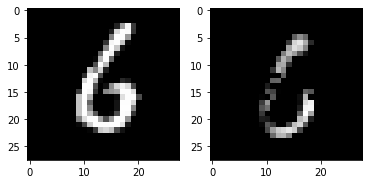

In [169]:
import matplotlib.pyplot as plt

for i_batch, data_batch in enumerate(test_loader):
    if i_batch > 0: 
        break
    with torch.no_grad():
        data_in, tgt = data_batch
        ii = 50
        #data_in0 = data_in[:1]
        data_in0 = data_in[ii:ii+1]
        data_in0 = data_in0.to(device)
        data_in1 = data_in0.cpu().squeeze(0).view(28,28).numpy()
        tgt0 = tgt[ii]
        out = ae.model(data_in0)
        out = out.cpu()
        out = out.squeeze(0)
        out = out.view(28,28).numpy()
        plt.subplot(1,2,1)
        plt.imshow(data_in1, cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(out, cmap='gray')
        print(tgt0.item())

## Stacked Autoencoder

In [170]:
dim_mnist = 784
dims = [784, 128, 64, 32]
dims2 = zip(dims, dims[1:])
dimsr = list(reversed(dims))
dims2r = zip(dimsr, dimsr[1:])
encoders = [ get_MLP(dim_arr) for dim_arr in dims2 ]
decoders = [ get_MLP(dim_arr) for dim_arr in dims2r ]
decodersr = list(reversed(decoders))
ae_layers = [ nn.Sequential(*encdec) for encdec in zip(encoders, decodersr) ]

class AE_Hidden(Dataset):
    def __init__(self, data):
        self.xs = data
        self.ys = data
        
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, ii):
        x = self.xs[ii]
        y = self.ys[ii]
        return x, y

In [171]:
"""
# train each ae_layer
# get data from each ae_layer
xdata = [tensorx.numpy() for tensorx, _ in train_set2]
xdata = torch.from_numpy(np.array(xdata))

hidden_loader = torch.utils.data.DataLoader(
    dataset=xdata.to(device),
    batch_size=batch_size,
    shuffle=True
)
"""
train_temp = [[x, x] for x, _ in train_set2]
hidden_loader = torch.utils.data.DataLoader(
    dataset=train_temp,
    batch_size=batch_size,
    shuffle=True
)

loss = nn.MSELoss()
for ae in ae_layers:
    ae = ae.to(device)
    optimizer = optim.Adam(ae.parameters())
    ae2 = Autoencoder(model=ae, loss=loss, optimizer=optimizer)
    
    ae2.run_train(100, hidden_loader)
    outs = ae2.encode(hidden_loader)
    dataset_out = AE_Hidden(outs)
    hidden_loader = torch.utils.data.DataLoader(
                    dataset=dataset_out,
                    batch_size=batch_size,
                    shuffle=False)

epoch 0 loss 0.23442285697338944
epoch 1 loss 0.22662248361413762
epoch 2 loss 0.22439515464386697
epoch 3 loss 0.22341766953468323
epoch 4 loss 0.22270010803210533
epoch 5 loss 0.2223265453920526
epoch 6 loss 0.22191128399917634
epoch 7 loss 0.22164000217187202
epoch 8 loss 0.22147253547179496
epoch 9 loss 0.22136642644971105
epoch 10 loss 0.22124801386716003
epoch 11 loss 0.22115942671642466
epoch 12 loss 0.2210767242615506
epoch 13 loss 0.22101818593376774
epoch 14 loss 0.2209739485534571
epoch 15 loss 0.22093422104746607
epoch 16 loss 0.22083542685387497
epoch 17 loss 0.2207831052147736
epoch 18 loss 0.22073199587353207
epoch 19 loss 0.22068617808616767
epoch 20 loss 0.2206574531935029
epoch 21 loss 0.22064410238447835
epoch 22 loss 0.22057285702834695
epoch 23 loss 0.2205066499063524
epoch 24 loss 0.22047547389895228
epoch 25 loss 0.22045593191001375
epoch 26 loss 0.22043210179623912
epoch 27 loss 0.22041055635880616
epoch 28 loss 0.2203639548713878
epoch 29 loss 0.220291801049547

In [166]:
# tuning stack
stacked_ae_model = nn.Sequential( *(encoders + decoders) )
stacked_ae_model = stacked_ae_model.to(device)

optimizer = optim.Adam(stacked_ae_model.parameters())
stacked_ae = Autoencoder(model=stacked_ae_model, loss=loss, 
                         optimizer=optimizer)
stacked_ae.run_train(10, train_loader)

epoch 0 loss 0.22431952998799792
epoch 1 loss 0.22399959283865103
epoch 2 loss 0.22388946517544278
epoch 3 loss 0.22382772777040125
epoch 4 loss 0.22375936490499368
epoch 5 loss 0.22369705405780824
epoch 6 loss 0.22364446975417057
epoch 7 loss 0.22355491428051966
epoch 8 loss 0.22350400219024238
epoch 9 loss 0.22346180614273428
epoch 10 loss 0.2234223640318644
epoch 11 loss 0.22338791343115144
epoch 12 loss 0.2233244058186725
epoch 13 loss 0.22331256937172453
epoch 14 loss 0.2232405965105962
epoch 15 loss 0.22320408853939025
epoch 16 loss 0.22314010295322387
epoch 17 loss 0.2231251169311798
epoch 18 loss 0.22309551539562517
epoch 19 loss 0.22301180925914796
epoch 20 loss 0.22296965134851002
epoch 21 loss 0.22292950951446922
epoch 22 loss 0.22288630422899278
epoch 23 loss 0.22287524213730278
epoch 24 loss 0.22282399287668325
epoch 25 loss 0.22278388198149407
epoch 26 loss 0.2227360551892701
epoch 27 loss 0.22271063936463856
epoch 28 loss 0.2226606464739573
epoch 29 loss 0.22264146110263

In [152]:
# compare with pre-training
# tuning stack
stacked_ae_model = nn.Sequential( *(encoders + decoders) )
stacked_ae_model = stacked_ae_model.to(device)

optimizer = optim.Adam(stacked_ae_model.parameters())
stacked_ae = Autoencoder(model=stacked_ae_model, loss=loss, 
                         optimizer=optimizer)
stacked_ae.run_train(10, train_loader)

epoch 0 loss 0.23225988851765456
epoch 1 loss 0.23009867056951686
epoch 2 loss 0.22855946850978723
epoch 3 loss 0.22711158228122583
epoch 4 loss 0.226039702735715
epoch 5 loss 0.22527510407617538
epoch 6 loss 0.22459564357995987
epoch 7 loss 0.22413398451724295
epoch 8 loss 0.22378846927214477
epoch 9 loss 0.22353328385595547


6


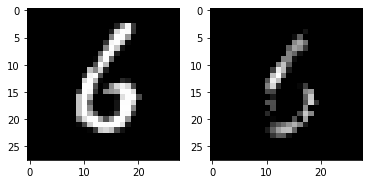

In [167]:
import matplotlib.pyplot as plt

for i_batch, data_batch in enumerate(test_loader):
    if i_batch > 0: 
        break
    with torch.no_grad():
        data_in, tgt = data_batch
        ii = 50
        #data_in0 = data_in[:1]
        data_in0 = data_in[ii:ii+1]
        data_in0 = data_in0.to(device)
        data_in1 = data_in0.cpu().squeeze(0).view(28,28).numpy()
        tgt0 = tgt[ii]
        out = stacked_ae.model(data_in0)
        out = out.cpu()
        out = out.squeeze(0)
        out = out.view(28,28).numpy()
        plt.subplot(1,2,1)
        plt.imshow(data_in1, cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(out, cmap='gray')
        print(tgt0.item())